# Main program GAIA-NIR

## Purpose

The main program handles the overall simulation flow by calling methods from the Spectrum and Parameters classes.\
The Spectrum class encapsulates all spectrum-related operations, including loading, processing, and saving the spectrum. \
The Parameters class handles configuration.


## Version History
- **v8.0**: Update: 

- Spectrum Class: Added Rescale & Generate Noise
- Modified plot method


Last Edited: 2025-03-17


## Flowchart of first overview of program

## Main program


In [1]:
import import_ipynb
import numpy as np
from spectrum import Spectrum
from parameters import Parameters

In [3]:
def main():
    """
    Main function to control the simulation flow.
    """
    params = Parameters()
    spectrum = Spectrum()

    #dirac_spectrum.txt
    #gaia_055000450000.txt
    
    spectrum.load_spectrum("gaia_055000450000.txt")
    spectrum.convert_units(parameters=params)
    
    spectrum.convolve_spectrum(parameters=params, apply_convolution=True)
    
    spectrum.resample_spectrum(parameters=params, verbose=True)

    spectrum.rescale_flux(parameters=params, verbose=True)

    for i in range(params.num_output_spectra):
        spectrum.radial_velocity_shift(verbose=(i == 0))  
        spectrum.resample_stochastic(verbose=(i == 0))  
        spectrum.generate_noise(parameters = params, verbose=(i == 0))  
        spectrum.save_spectrum(output_file=f"output_spectrum_{i+1:03d}.txt")

    print("Simulation complete.")

[load_spectrum] Loading spectrum from 'gaia_055000450000.txt
[load_spectrum] Spectrum loaded correctly.
[convert_units] Converted units to Ångströms.
[convolve_spectrum] Sigma wavelength units: 0.32 Å, pixel units: 31.94
[convolve_spectrum] Gaussian convolution completed.
[convolve_spectrum] Flux before & after convolution: 1887638878.000 | 1887638755.168
[convolve_spectrum] Flux conservation ratio: 1.000000


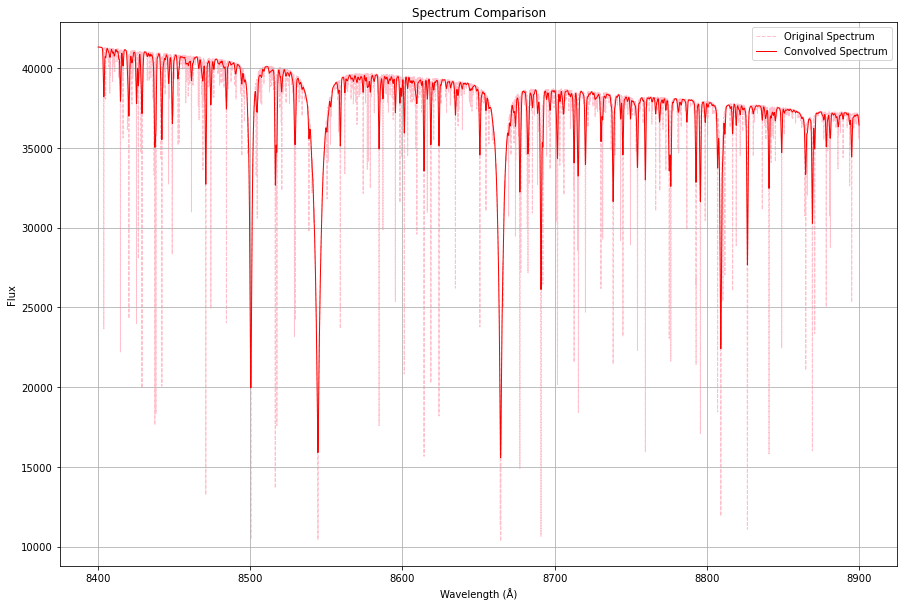

[resample_spectrum] Resampling completed.
[resample_spectrum] First: 8400.00 Å, Center:8650.0 Å, Last: 8900.00 Å
[resample_spectrum] Pixel size: 0.25 Å, New grid points: 2001


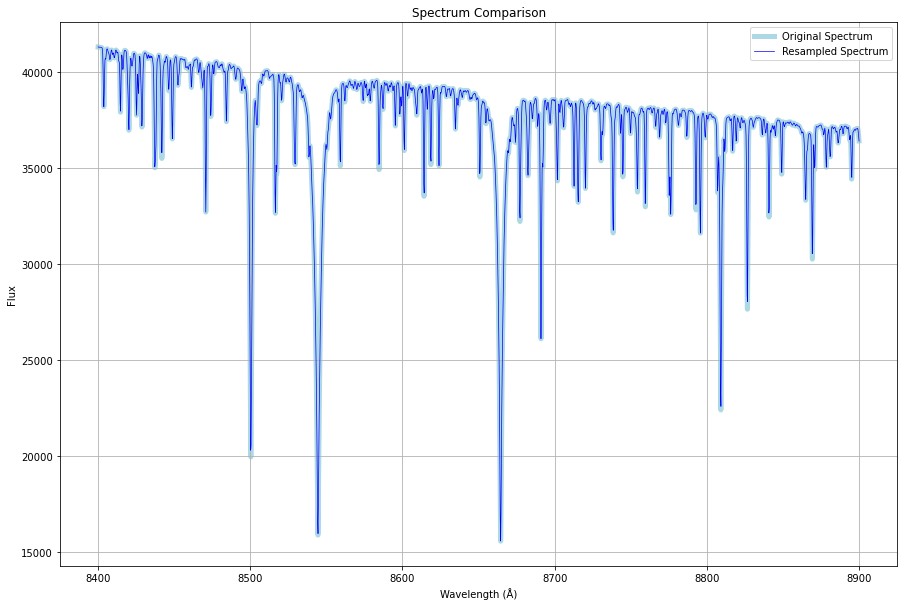

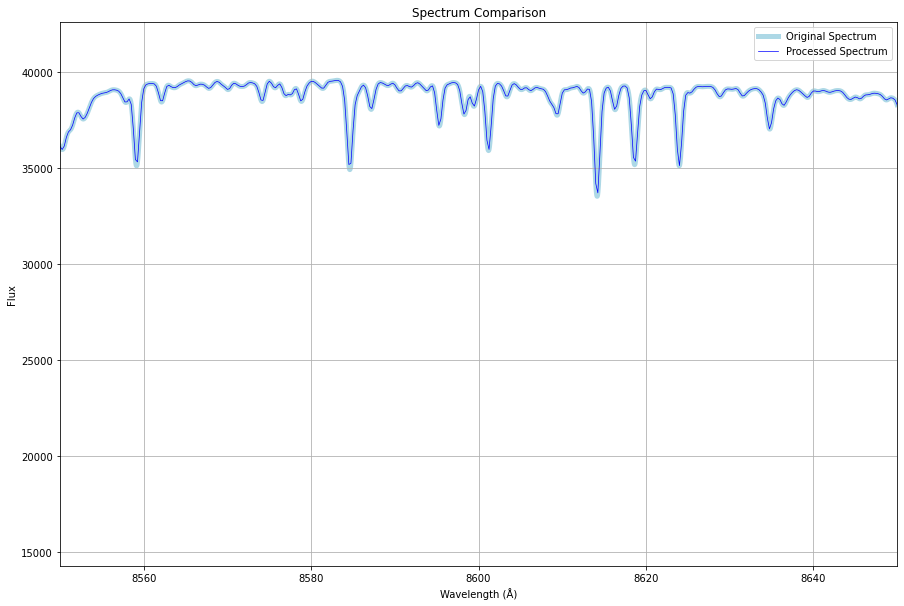

[rescale_flux] Reference flux level before : 39577.822
[rescale_flux] Max flux after: 2500.000
[rescale_flux] Rescaling completed.


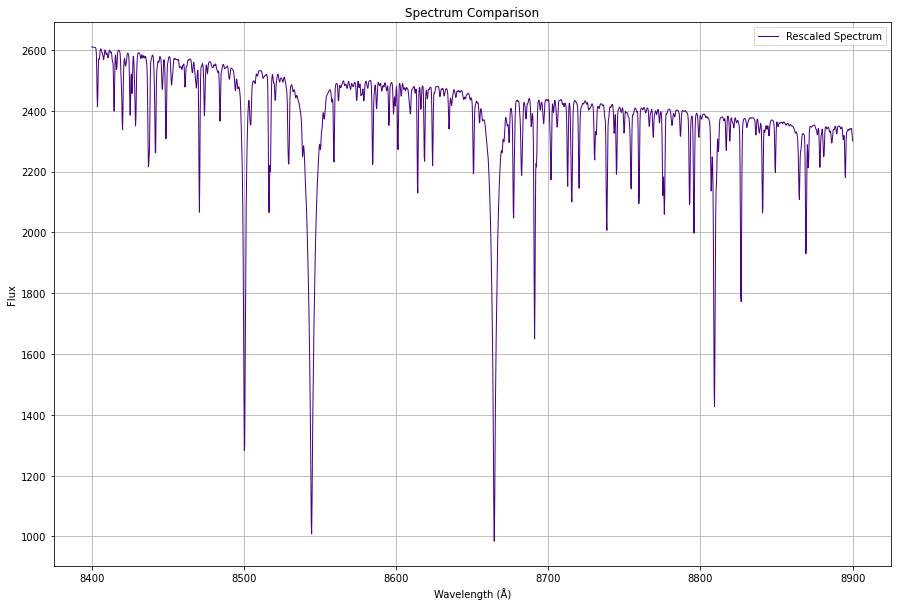

[radial_velocity_shift] Applying radial velocity shift
[resample_stochastic] Resampling spectrum for stochastic process
[generate_noise] Noise standard deviation: 0.978 (Expected: 0.976)
[generate_noise] Noise generation completed.


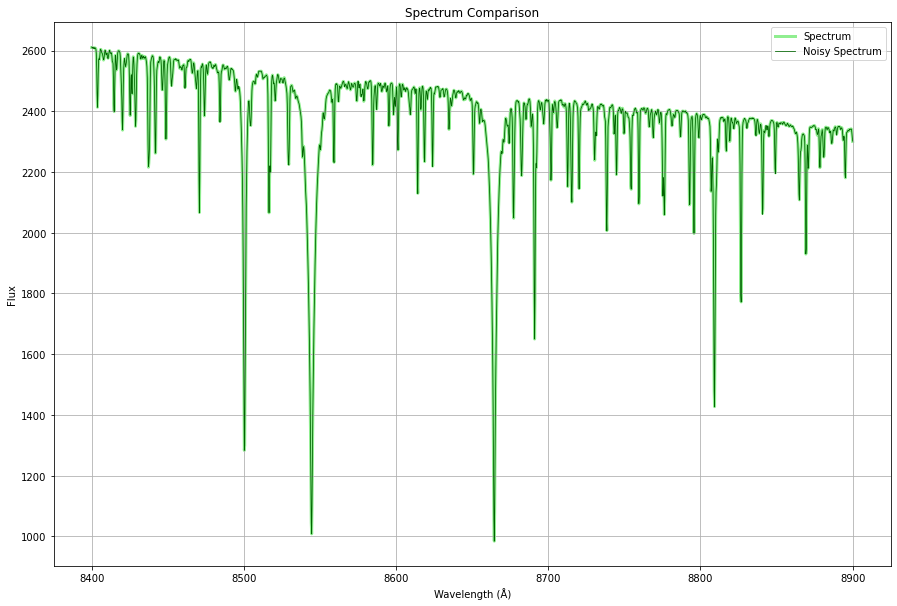

[save_spectrum] Spectrum saved to 'output_spectrum_001.txt'.
Simulation complete.


In [4]:
main()